In [1]:
import os
import nltk
import nltk.corpus
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Importing and looking at the data

In [2]:
df = pd.read_csv ("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         60000 non-null  int64 
 1   comment    60000 non-null  object
 2   subreddit  60000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [3]:
df.head()

,id,comment,subreddit
0,0,I think prestige points should not expire ever...,leagueoflegends
1,1,Whats going to happen with them if they will b...,europe
2,2,Anecdotal evidence is anecdotal. Clearly by “e...,gameofthrones
3,3,"Look dude, with all due respect, your music is...",Music
4,4,Hope he gets the doomhammer back!,wow


# Data cleaning (Training comments)

In [4]:
def clean_text(df):
    
    all_comments = list()
    lines = df["comment"].values.tolist()
    for text in lines:
        text = text.lower()
        
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub("", text)
        
        emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = emoji.sub(r'', text)
        
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)
        text = re.sub(r"nt", "not", text)
    
        
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        
        tokens = word_tokenize(text)
        
        table = str.maketrans('', '', string.punctuation)
        
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        
        stop_words = set(stopwords.words("english"))
        stop_words.discard("not")
        
        words = [w for w in words if not w in stop_words]
        words = ' '.join(words)
        
        all_comments.append(words)
    return all_comments

all_comments = clean_text(df)
all_comments[0:2]

['think prestige poinots not expire ever skins buy available set duration exemple year release another skin vault old one making also limitededition skin also please love god not rerelease skins need grind prestige shop would suck everyone grinded',
 'whats going happen refused asilum appeal']

# Most frequent used words

In [5]:
c = all_comments
filtered_sentence = [] 
freq_count_limit = FreqDist()
lemmatizer=WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

for i in c:
    comment_tokens = word_tokenize(i)
    
    for words in comment_tokens:
        if words not in stop_words: 
            filtered_sentence.append(words) 
        
            limit_words = lemmatizer.lemmatize(words)
#     for word in root_words:
            freq_count_limit[limit_words.lower()]+=1
freq_count_limit

FreqDist({'like': 8954, 'would': 7132, 'nt': 6837, 'one': 5971, 'people': 5884, 'get': 5839, 'think': 4498, 'time': 4385, 'game': 3900, 'even': 3839, ...})

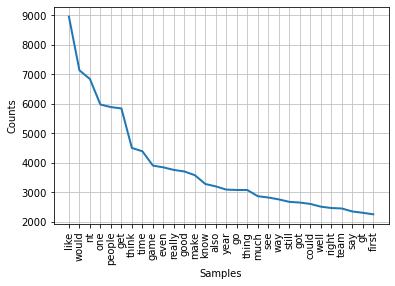

In [6]:
freq_count_limit.plot(30,cumulative=False)
plt.show()

# Vectorizing and transforming the text

In [38]:
vect = TfidfVectorizer(ngram_range=(1,1), max_features=30000, strip_accents='ascii')
vect.fit(all_comments)
vocabulaire = vect.get_feature_names()

In [39]:
bag_of_words = vect.transform(all_comments)
bag_of_words.shape

(60000, 30000)

# Spliting the test and train datasets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df['subreddit'], 
                                                    test_size = 0.001, 
                                                    random_state = 42, 
                                                    shuffle=True)

# NaiveBayes classifier

In [41]:
# class NaiveBayes:
#     def fit(self, X, y):
#         n_samples, n_features = X.shape
#         self._classes = np.unique(y)
#         n_classes = len(self._classes)
        
#         # init mean, var, priors
#         self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
#         self._vae = np.zeros((n_classes, n_features), dtype=np.float64)
#         self._priors = np.zeros(n_classes, dtype=np.float64)
        
#         for c in self._classes:
#             X_c = X[c==y]
#             self._mean[c,:]=X_c.mean(axis=0)
#             self._var[c,:]=X_c.mean(axis=0)
#             self._priors[c]=X_c.shape[0] / float(n_samples) # The frequently of how class c is happening
            
            
            
            
#     def predict(self, X): # For multiple samples
#         y_pred = [self._predict(x) for x in X]
#         return y_pred
        
#     def _predict(self, x):  # For single samples
#         posteriors = []
        
#         for idx, c in enumerate(self.classes):
#             prior = np.log(self.priors[idx])
#             class_conditional = np.sum(np.log(self._pdf(idx, x)))
#             posterior = prior + class_conditional
#             posteriors.append(posterior)
            
            
#         return self._classes[np.argmax(posteriors)]
            
# # Probability density function     
#     def _pdf(self, class_idx, x):
#         mean = self._mean[class_idx]
#         var = self._var[class_idx]
# # Exponential function
#         numerator = np.exp(- (x-mean)**2 / (2 * var))  
#         denominator = np.sqr(2* np.pi * var)
#         return numerator / denominator
    
        
        

# Prediction

In [42]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
predicted= clf.predict(X_test)

In [43]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy
print("Naive Bayes classification accuracy", accuracy(y_test, predicted))

Naive Bayes classification accuracy 0.5333333333333333


# Naive Bayes - Cross Validation

In [46]:
scores_main = cross_val_score(clf, bag_of_words, df['subreddit'], cv=5)
scores_main

array([0.416     , 0.39816667, 0.41041667, 0.41266667, 0.41158333])

# TEST dataset

In [48]:
df_test = pd.read_csv ("test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       20000 non-null  int64 
 1   comment  20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


In [49]:
df_test.head()

,id,comment
0,0,Holy shit a shot counter.
1,1,It doesn't matter that it isn't hard to rememb...
2,2,I find it funny that this is downvoted
3,3,They are really getting ridicoulous with all t...
4,4,He's Eden's best friend


# Data cleaning (Testing comments)

In [50]:
cleaned_test = clean_text(df_test)
cleaned_test[0:2]

['holy shit shot counoter',
 'nt matter nt hard remember fractions nt complicated right poinot everyone trying make fractions unnecessarily harder using metric system metric wrenches drill bits stuff go millimeters mm bigger size previous one need able counot undeniably easier fractions']

# Text transformation

In [51]:
cleaned_test_vect = vect.transform(cleaned_test)

# Prediction on test dataset

In [52]:
y_pred = clf.predict(cleaned_test_vect)

# Submission

In [53]:
submission = zip(list(range(len(y_pred))), y_pred)
test_df = pd.DataFrame(submission, columns=['Id','Category'])
test_df.to_csv('submission.csv', index = False, header=True)

# Random Forest

In [20]:
# clf_rf = RandomForestClassifier(max_depth=10, random_state=42)
# clf_rf.fit(bag_of_words, df['subreddit'])


In [21]:
# clf_rf.score(bag_of_words, df['subreddit'])

# Random Forest - Cross Validation

In [22]:
# scores_rf = cross_val_score(clf_rf, bag_of_words, df['subreddit'], cv=5)
# scores_rf

# Logistic Regression

In [23]:
# clf_lr = LogisticRegression(max_iter=20, random_state=42)
# clf_lr.fit(bag_of_words, df['subreddit'])


In [24]:
# clf_lr.score(bag_of_words, df['subreddit'])

# Logistic Regression - Cross Validation

In [25]:
# scores_lr = cross_val_score(clf_lr, bag_of_words, df['subreddit'], cv=5)
# scores_lr